# Bayesian/Frequentist Tutorial

In [1]:
import arviz as az
import bambi as bmb
import numpy as np
import pandas as pd
import pymc3 as pm

import matplotlib.pyplot as plt

from pymer4.simulate import simulate_lm, simulate_lmm
from pymer4.models import Lmer, Lm
from scipy.stats import ttest_ind

/home/osvaldo/anaconda3/lib/python3.7/site-packages/rpy2/robjects/pandas2ri.py:14: FutureWarning: pandas.core.index is deprecated and will be removed in a future version.  The public classes are available in the top-level namespace.
  from pandas.core.index import Index as PandasIndex
INFO:numexpr.utils:NumExpr defaulting to 4 threads.


In [2]:
az.style.use('arviz-darkgrid')

In this notebook we demo how to perform the same set of analyses using a frequentist approach and a bayesian approach.  
We'll perform two sets of analyses:  
1) Simple between groups t-test (i.e. univariate regression with dummy-coding)   
2) Multi-level multivariate regression model (with two predictors)  
We'll estimate the frequentist statistics using [pymer4](http://eshinjolly.com/pymer4/).  

## Generate t-test data

In [3]:
a = np.random.normal(5,2,1000)
b = np.random.normal(8,2.5,1000)
df = pd.DataFrame({'Group':['a']*1000 + ['b']*1000,'Val':np.hstack([a,b])})

In [4]:
df.groupby('Group').describe()

Val                                                              \
        count      mean       std       min       25%       50%       75%   
Group                                                                       
a      1000.0  4.901747  1.955774 -0.900373  3.586848  4.961405  6.163554   
b      1000.0  7.975125  2.518749 -2.232115  6.278875  8.002316  9.669793   

                  
             max  
Group             
a      11.872290  
b      14.847826

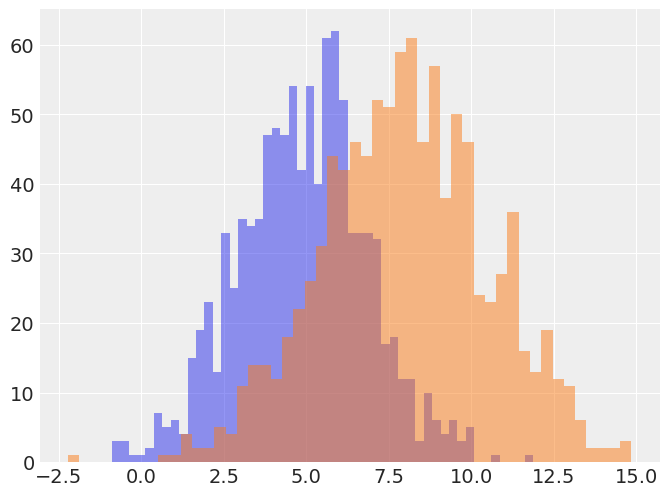

In [5]:
f,ax = plt.subplots(1,1,figsize=(8,6))
ax.hist(a,alpha=.5,bins=50);
ax.hist(b,alpha=.5,bins=50);

### Frequentist  
Since this analysis is relateively straightforward we can perform a between groups t-test using scipy

In [6]:
ttest_ind(b,a)

Ttest_indResult(statistic=30.477105041971846, pvalue=7.2541984106044045e-168)

We can also set this up as a dummy-coded univariate regression model which is identical

In [7]:
# Using the pymer4 package, but we could have used statsmodels instead
model = Lm('Val ~ Group',data=df)
model.fit()

Formula: Val~Group

Family: gaussian	 Estimator: OLS

Std-errors: non-robust	CIs: standard 95%	Inference: parametric 

Number of observations: 2000	 R^2: 0.317	 R^2_adj: 0.317

Log-likelihood: -4463.088 	 AIC: 8930.176	 BIC: 8941.378

Fixed effects:



,Estimate,2.5_ci,97.5_ci,SE,DF,T-stat,P-val,Sig
Intercept,4.902,4.762,5.042,0.071,1998,68.742,0.0,***
Group[T.b],3.073,2.876,3.271,0.101,1998,30.477,0.0,***


### Bayesian
We can compute the equivalent dummy-coded regression model to estimate with bambi and the pymc3 backend

In [8]:
b_model = bmb.Model(df)
res_b = b_model.fit('Val ~ Group', samples=1000, tune=1000) 

Auto-assigning NUTS sampler...
INFO:pymc3:Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO:pymc3:Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
INFO:pymc3:Multiprocess sampling (2 chains in 2 jobs)
NUTS: [Val_sd, Group, Intercept]
INFO:pymc3:NUTS: [Val_sd, Group, Intercept]


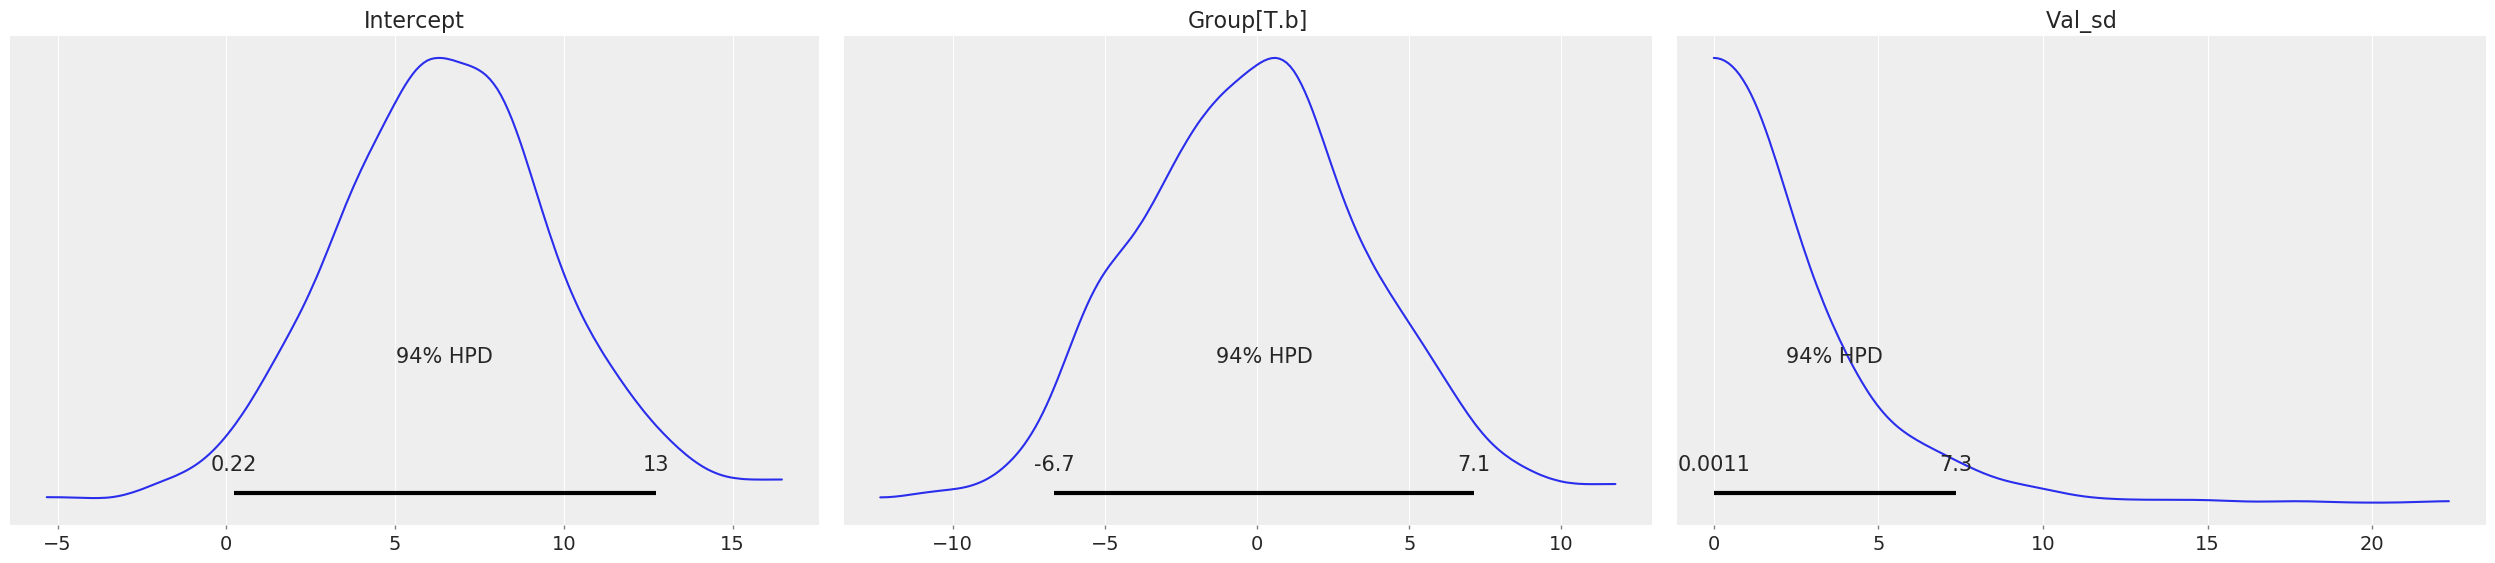

In [9]:
# Model priors
b_model.plot();

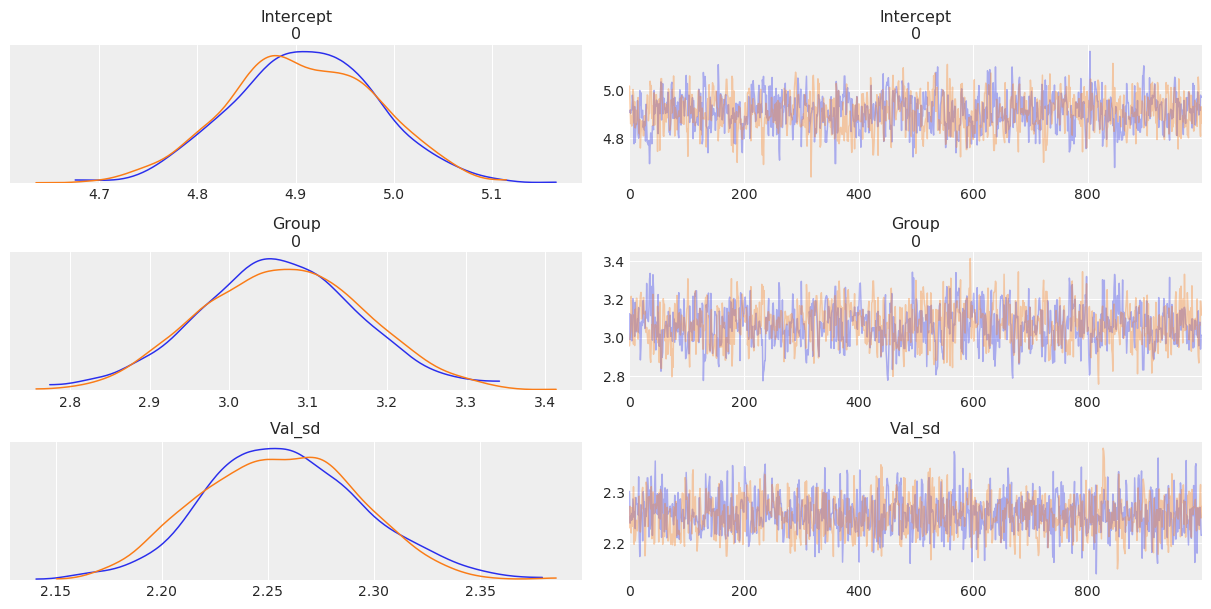

In [10]:
az.plot_trace(res_b);

In [11]:
az.summary(res_b)

,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
Intercept[0],4.908,0.073,4.775,5.047,0.003,0.002,780.0,780.0,788.0,1197.0,1.0
Group[0],3.066,0.101,2.866,3.245,0.004,0.003,723.0,717.0,726.0,1067.0,1.0
Val_sd,2.257,0.037,2.193,2.329,0.001,0.001,1549.0,1545.0,1563.0,1408.0,1.0


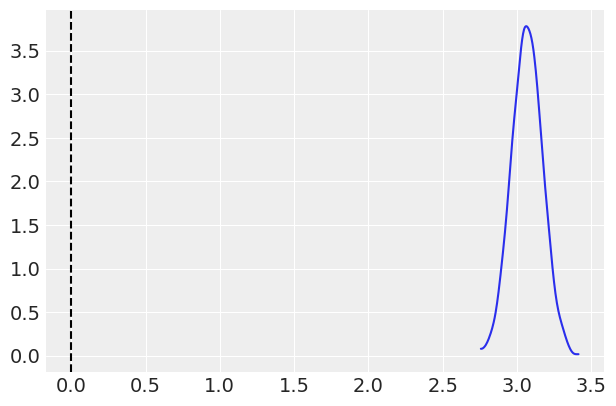

In [12]:
# Grab just the posterior of the term of interest (group)
group_posterior = res_b.posterior['Group'].values
ax = az.plot_kde(group_posterior)
ax.axvline(0, 0, 3, linestyle='--', color='k');

In [13]:
#Probabiliy that posterior is > 0
(group_posterior > 0).mean()

1.0

## Generate multi-level regression data

Generate data for a multivariate regression model with random intercepts and slope effect for each group

In [14]:
# Simulate some multi-level data with pymer4
df, blups, coefs = simulate_lmm(num_obs=500, num_coef=2, num_grps=25, coef_vals=[5,3,-1])
df.head()
blups.head()

,Intercept,IV1,IV2
Grp1,5.078462,2.965038,-0.809101
Grp2,5.038959,3.389151,-0.728827
Grp3,4.711509,2.892428,-1.009656
Grp4,4.916194,2.633570,-0.881529
Grp5,5.069100,3.195954,-1.023484


### Frequentist multi-level model

In [15]:
# Fit multi-level model using pymer4 (lmer in R)
model = Lmer('DV ~ IV1 + IV2 + (IV1 + IV2|Group)',data=df)
model.fit()

Model failed to converge with max|grad| = 0.0024797 (tol = 0.002, component 1) 

Formula: DV~IV1+IV2+(IV1+IV2|Group)

Family: gaussian	 Inference: parametric

Number of observations: 12500	 Groups: {'Group': 25.0}

Log-likelihood: -17857.782 	 AIC: 35715.565

Random effects:

                 Name    Var    Std
Group     (Intercept)  0.057  0.238
Group             IV1  0.081  0.285
Group             IV2  0.055  0.235
Residual               0.998  0.999

               IV1  IV2   Corr
Group  (Intercept)  IV1 -0.020
Group  (Intercept)  IV2  0.149
Group          IV1  IV2 -0.115

Fixed effects:



,Estimate,2.5_ci,97.5_ci,SE,DF,T-stat,P-val,Sig
(Intercept),5.008,4.913,5.103,0.048,24.002,103.450,0.0,***
IV1,3.015,2.902,3.128,0.058,24.031,52.268,0.0,***
IV2,-0.897,-0.991,-0.803,0.048,24.000,-18.706,0.0,***


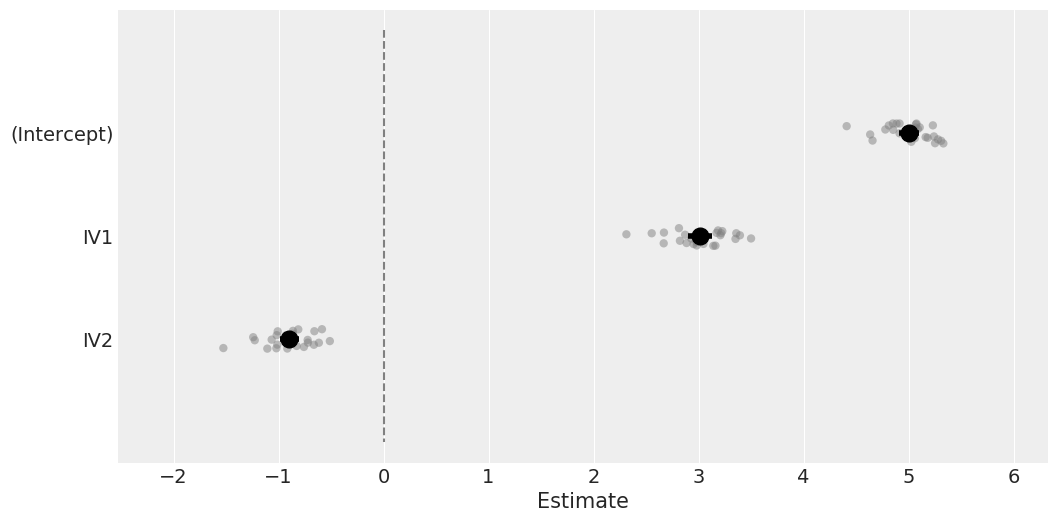

In [16]:
# Plot coefficients and the group BLUPs as well
model.plot_summary();

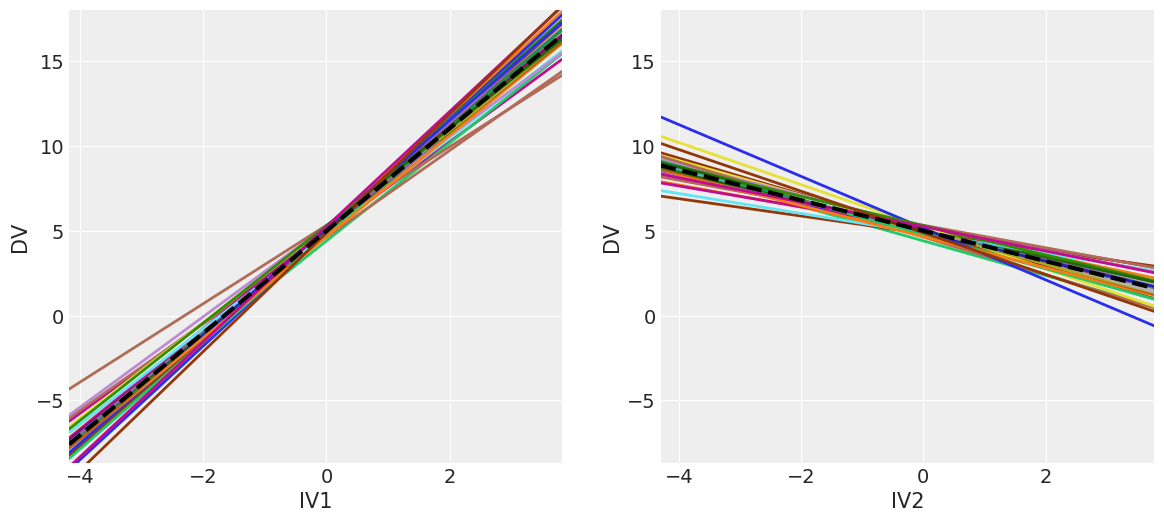

In [17]:
# Alternatively visualize coefficients as regression lines with BLUPs overlaid
_, axs = plt.subplots(1, 2, figsize=(14, 6))
model.plot('IV1', ax=axs[0],)
model.plot('IV2', ax=axs[1]);

### Bayesian multi-level model

In [18]:
b_model = bmb.Model(df)
results = b_model.fit('DV ~ IV1 + IV2',random=['IV1+IV2|Group'], samples=1000, tune=1000)

Auto-assigning NUTS sampler...
INFO:pymc3:Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
INFO:pymc3:Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
INFO:pymc3:Multiprocess sampling (2 chains in 2 jobs)
NUTS: [DV_sd, IV2|Group_offset, IV2|Group_sd, IV1|Group_offset, IV1|Group_sd, 1|Group_offset, 1|Group_sd, IV2, IV1, Intercept]
INFO:pymc3:NUTS: [DV_sd, IV2|Group_offset, IV2|Group_sd, IV1|Group_offset, IV1|Group_sd, 1|Group_offset, 1|Group_sd, IV2, IV1, Intercept]


The estimated number of effective samples is smaller than 200 for some parameters.
ERROR:pymc3:The estimated number of effective samples is smaller than 200 for some parameters.


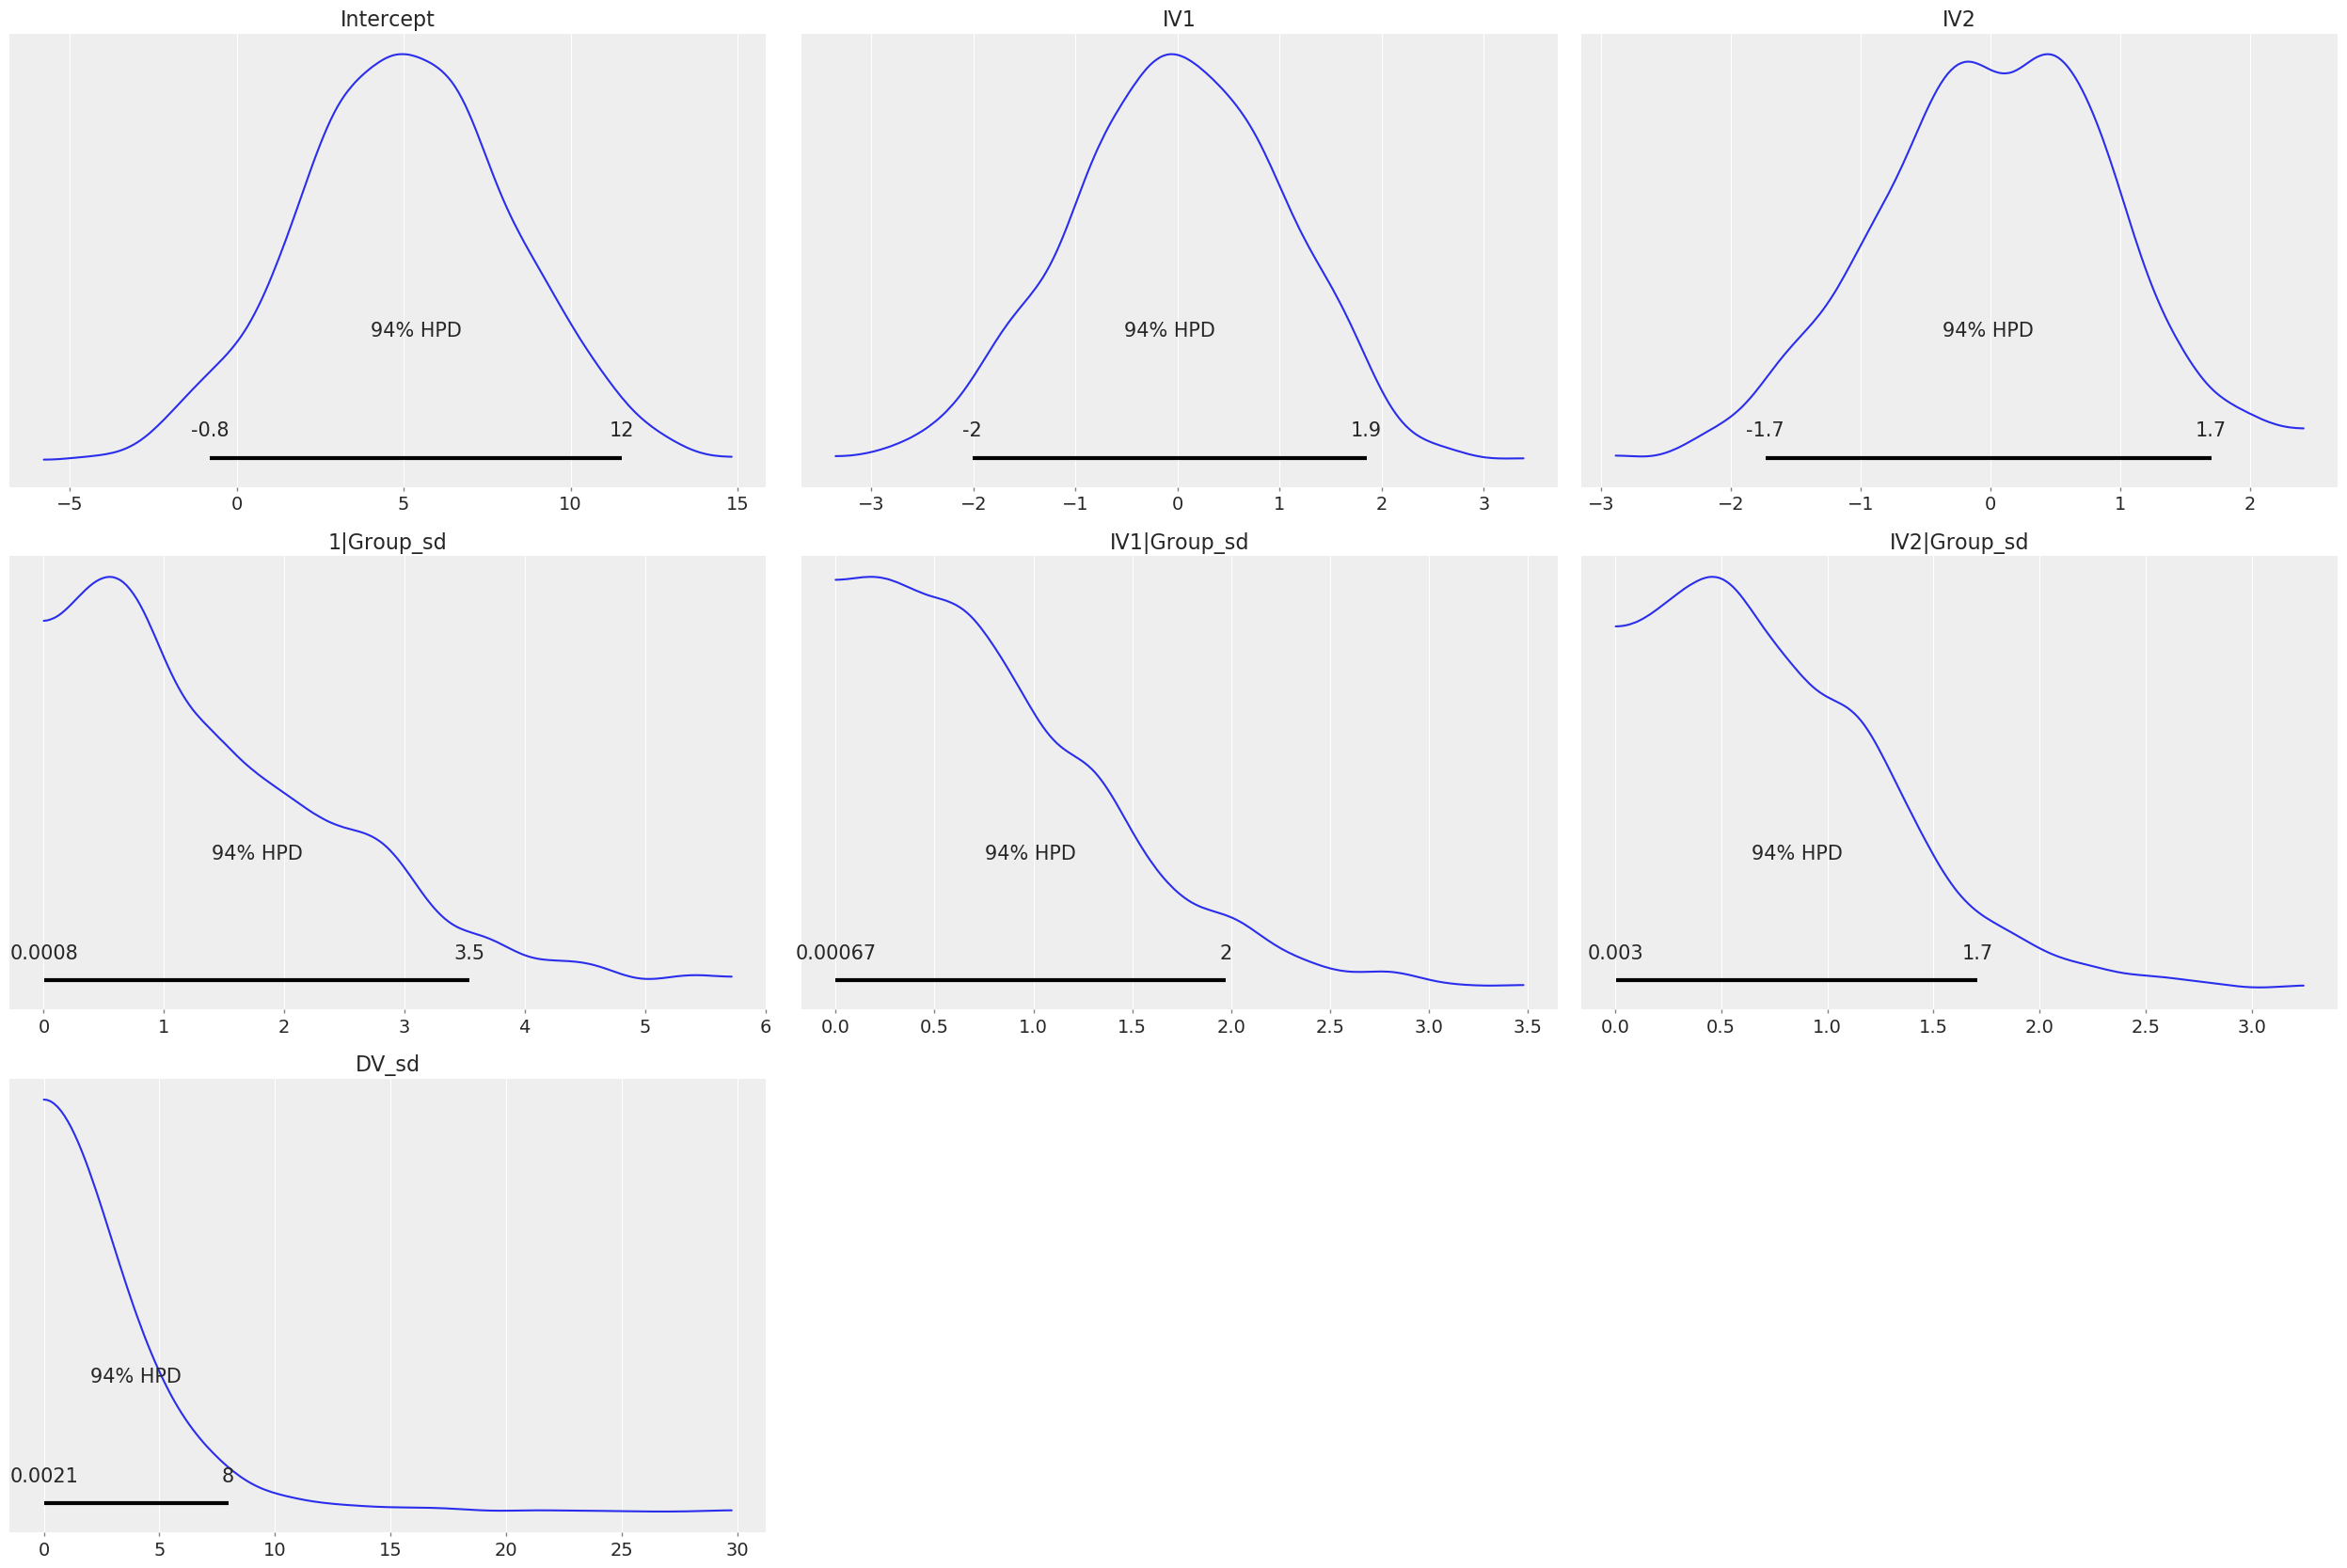

In [19]:
# Plot priors
b_model.plot();

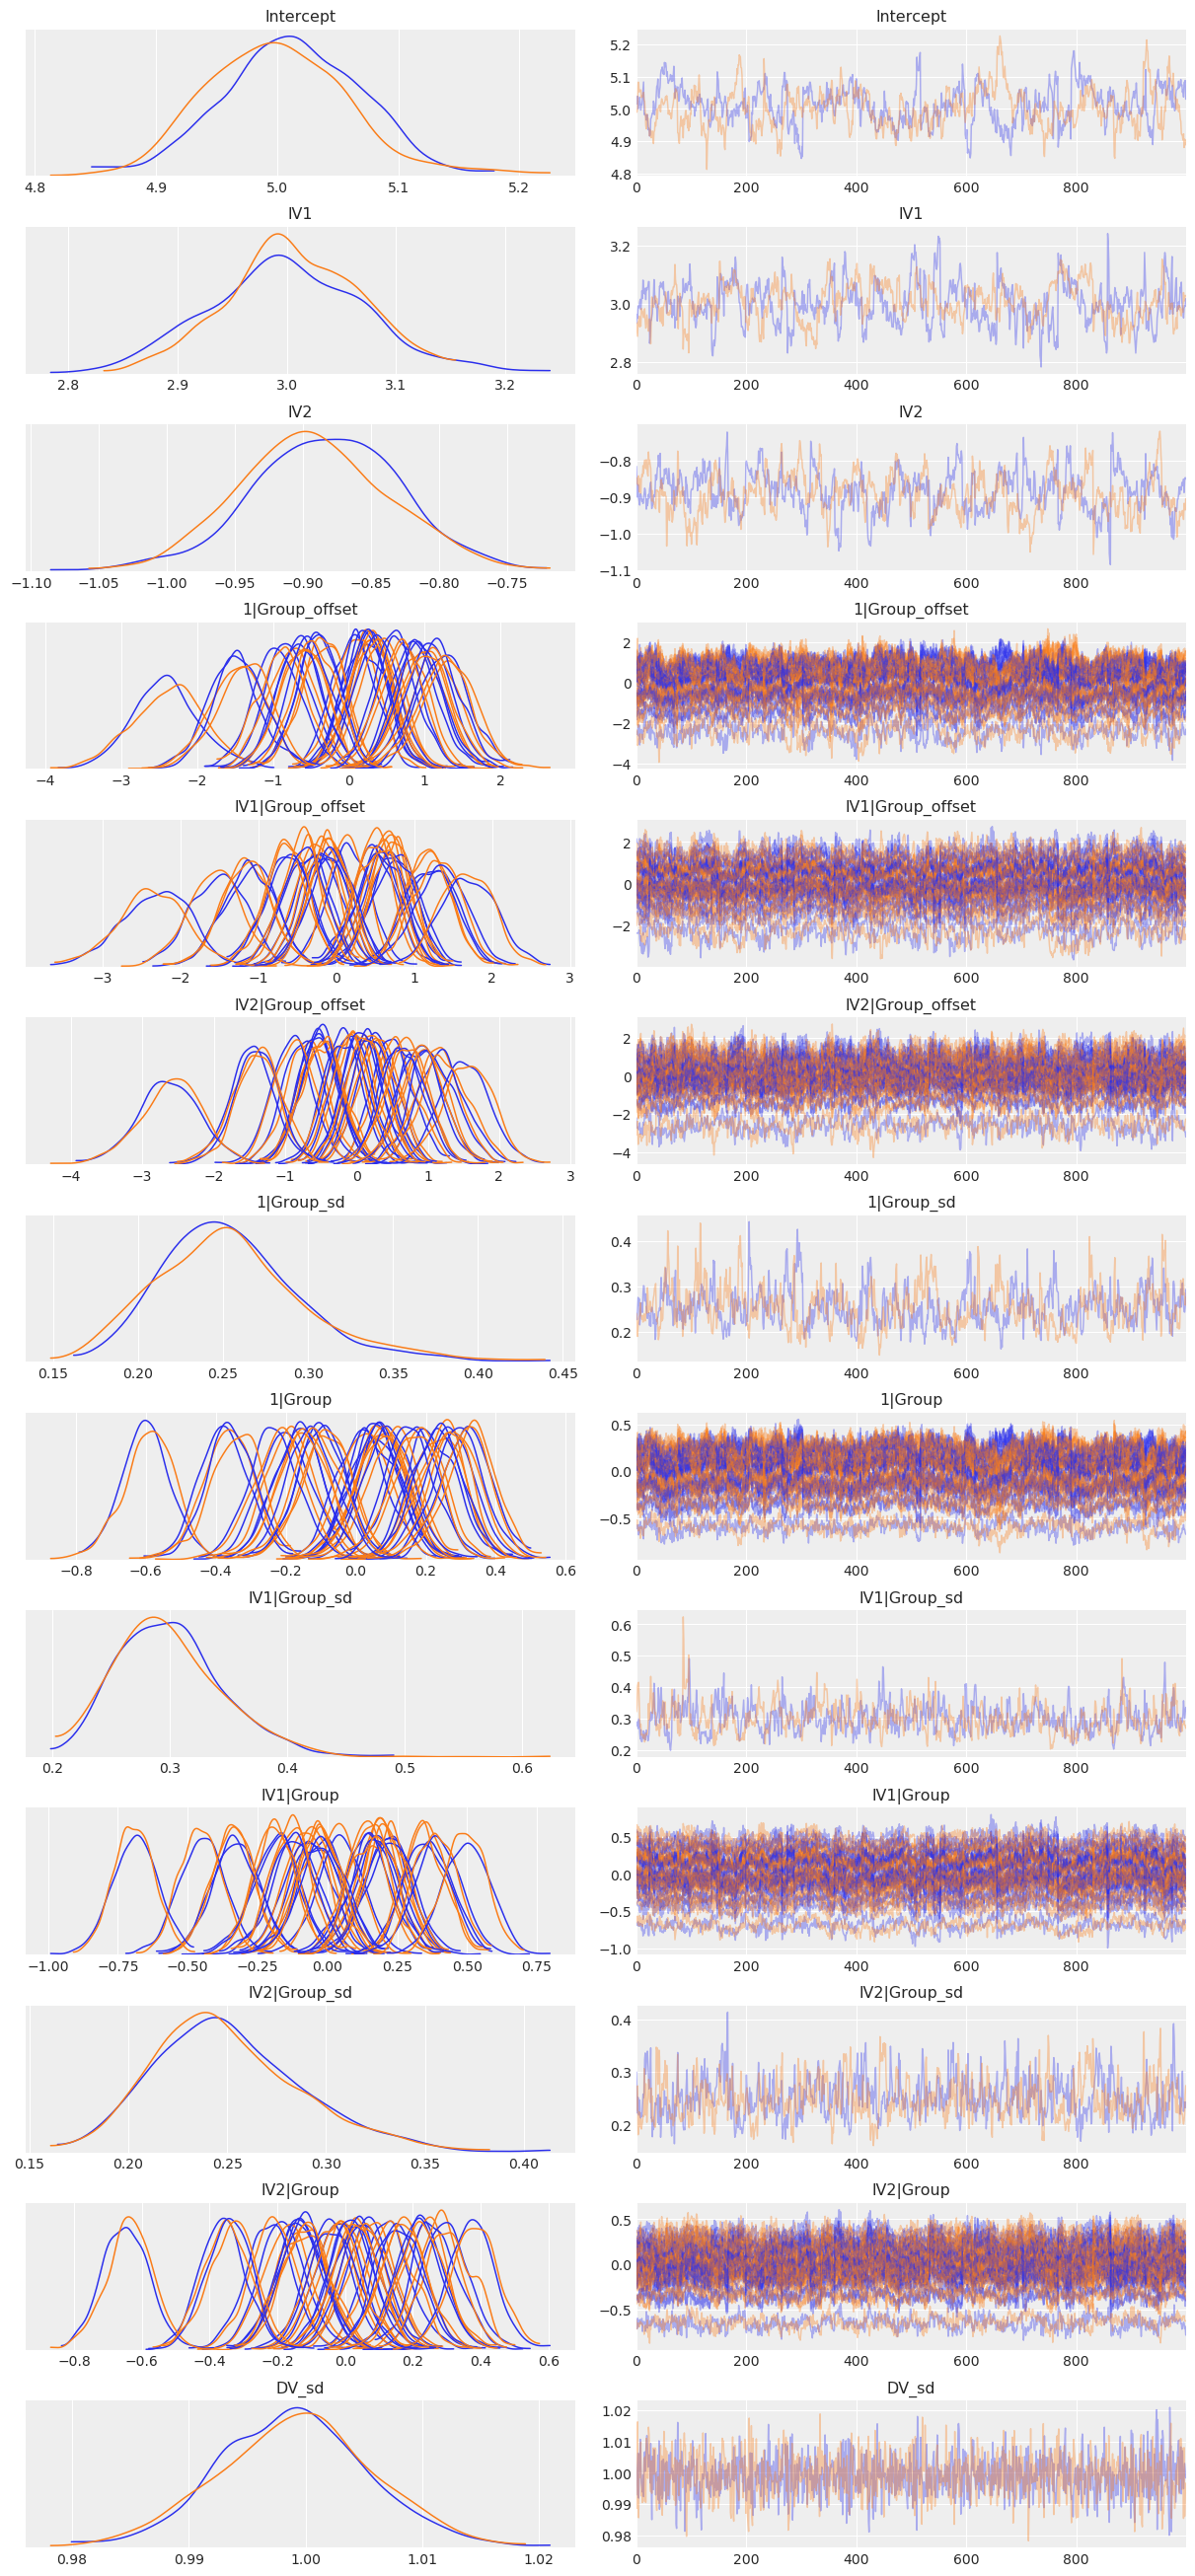

In [20]:
#Plot posteriors
az.plot_trace(results, compact=True);

In [21]:
az.summary(results,
          var_names=['Intercept', 'IV1', 'IV2', '1|Group_sd', 'IV1|Group_sd', 'IV2|Group_sd', 'DV_sd'])

,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
Intercept[0],5.007,0.059,4.903,5.117,0.005,0.003,142.0,141.0,143.0,256.0,1.01
IV1[0],3.003,0.067,2.885,3.137,0.005,0.004,160.0,160.0,159.0,397.0,1.01
IV2[0],-0.888,0.055,-0.988,-0.779,0.005,0.003,146.0,144.0,146.0,298.0,1.01
1|Group_sd,0.255,0.043,0.175,0.334,0.003,0.002,221.0,221.0,216.0,457.0,1.00
IV1|Group_sd,0.300,0.045,0.218,0.382,0.003,0.002,314.0,314.0,309.0,622.0,1.01
IV2|Group_sd,0.251,0.038,0.183,0.322,0.002,0.001,322.0,322.0,319.0,559.0,1.00
DV_sd,0.999,0.007,0.988,1.012,0.000,0.000,1919.0,1919.0,1917.0,1526.0,1.00


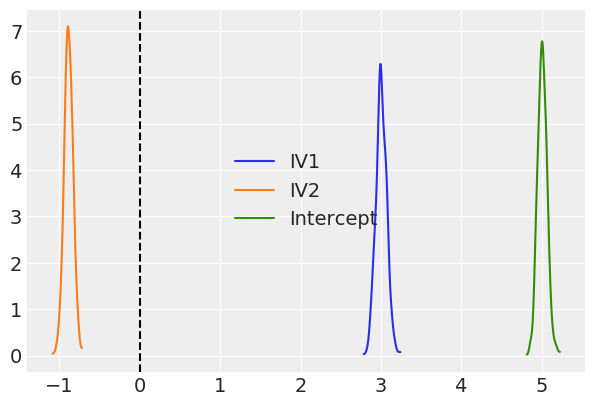

In [22]:
az.plot_kde(results.posterior['IV1'], plot_kwargs={'color': 'C0'}, label='IV1')
az.plot_kde(results.posterior['IV2'], plot_kwargs={'color': 'C1'}, label='IV2')
az.plot_kde(results.posterior['Intercept'], plot_kwargs={'color': 'C2'}, label='Intercept')
plt.axvline(0, color='k', linestyle='--')
plt.legend();

Because we used pymc3 for the backend estimation in bambi, we have access to few extra goodies. Here we make a forest plot similar to the one above for the frequentist model, but with 94% credible intervals instead

INFO:numba.transforms:finding looplift candidates


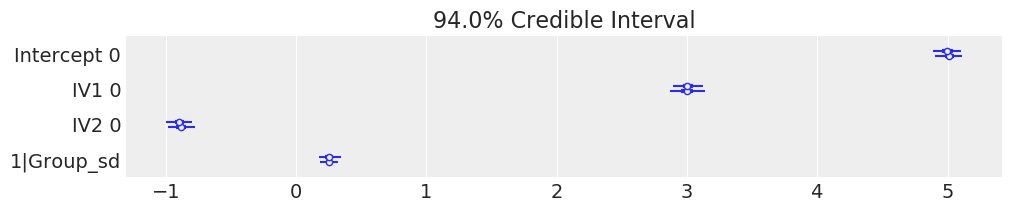

In [23]:
# Credible interval plot using pymc3
# Line is 94% credible interval calculated as higher posterior density
# Inter quartile range is thicker line
# Dot is median
az.plot_forest(results, var_names=['Intercept', 'IV1', 'IV2', '1|Group_sd'], figsize=(10, 2));

We can also plot the posterior overlayed with a region of practical equivalence (ROPE), i.e. range of values that were the coefficients to fall into, we might interpret them differently. 
We can see that all our posterior distributions fall outside of this range.

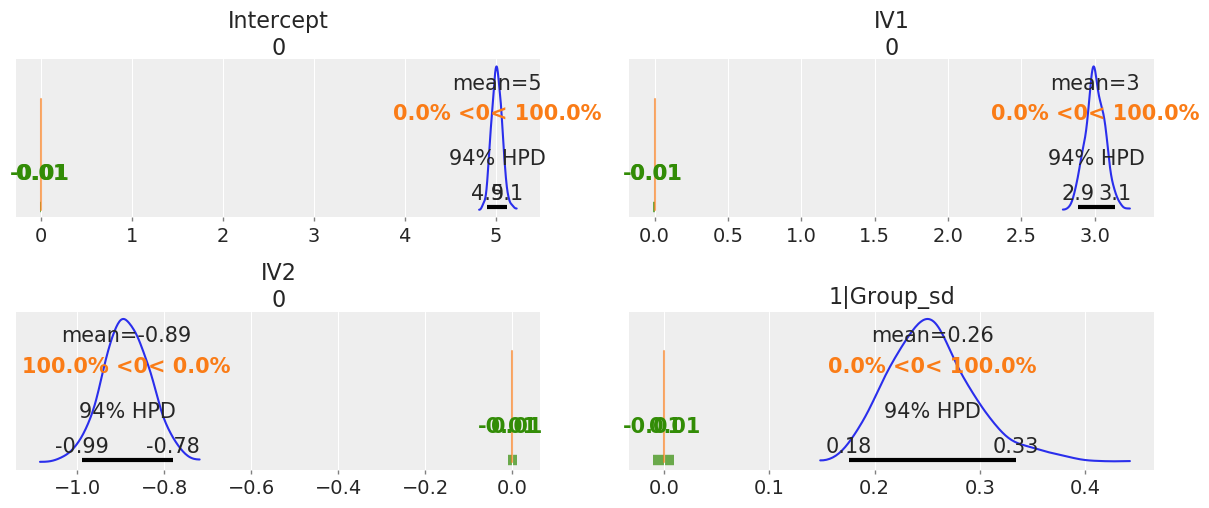

In [24]:
# Show credible interval cutoffs, and also overlay region of practical equivalence (arbitrary, in this case close enough to 0 to not matter)
_, ax = plt.subplots(2, 2, figsize=(12, 5), constrained_layout=True)
az.plot_posterior(b_model.backend.trace,
                  var_names=['Intercept', 'IV1', 'IV2', '1|Group_sd'],
                  ref_val=0,
                  rope=[-.01, .01],
                  ax=ax);